# Measuring a Mutiport Device with a 2-Port Network Analyzer

## Introduction

This notebook demonstrates a numerical test of the technique described in 
"*A Rigorous Technique for Measuring the Scattering Matrix of a Multiport Device with a 2-Port Network Analyzer*" [1].

In microwave measurements,  one commonly needs to measure a n-port deveice  with a m-port network analyzer ($ m<n $ of course). Generally, this is done by  terminating each non-measured port with a matched load, and assuming the reflected power is negligable. However, in some cases this may not provide the most accurate results, or even be possible in all measurement environments. The paper above presents an elegent solution to this problem, using impedance renormalization. We'll call it *Tippet's technique*, because it has a good ring to it.

In *Tippets technique*, several sub-networks are measured in a similar way as before, but the port terminations are not assumed to be matched. Instead, the terminations just have to be known and no more than one can be completely reflective. So, in general $|\Gamma| \ne 1$. During measurements, each port is terminated with a consistent termination. So port 1 is always terminated with $Z_1$ when not being measured. Once measured, each sub-network is re-normalized to these port impedances. Think about that.  Finally the composit network is contructed, and  may then be re-normalized to the desired system impedance, say $50 ohm $ 



* [1] J. C. Tippet and R. A. Speciale, “A Rigorous Technique for Measuring the Scattering Matrix of a Multiport Device with a 2-Port Network Analyzer,” IEEE Transactions on Microwave Theory and Techniques, vol. 30, no. 5, pp. 661–666, May 1982.


## Outline of Tippet's Technique

Following the example given in [1], measuring a 4-port network with a 2-port network analyzer.

An outline of the technique: 

1. Calibrate 2-port network analyzer
2. Get four known terminations ($Z_1, Z_2, Z_3,Z_4$). No more than one can have  $|\Gamma| = 1$
3. Measure all combinations of 2-port subnetworks (there are 6). Each port not currently being measured must be terminated with its corresponding load.
4. Renormalize each subnetwork to the impedances of the loads used to terminate it when note being measured. 
5. Build composite 4-port, renormalize to VNA impedance. 

## Implementation

In [1]:
import skrf as rf 
from itertools import combinations

First, we create a Media object, which is used to generate networks for testing. We will use WR-10 Rectangular waveguide.

In [2]:
wg = rf.wr10
wg.frequency.npoints = 101

Next, lets generate a random 4-port network which will be the DUT, that we are trying to measure with out 2-port network analyzer. 

In [3]:
dut = wg.random(n_ports  = 4,name= 'dut')
dut

4-Port Network: 'dut',  75-110 GHz, 101 pts, z0=[ 50.+0.j  50.+0.j  50.+0.j  50.+0.j]

Now, we need to define the loads used to terminate each port when it is not being measured, note as described in [1] not more than one can be have full reflection, $|\Gamma| = 1$

In [4]:
loads = [wg.load(.1+.1j),
         wg.load(.2-.2j),
         wg.load(.3+.3j),
         wg.load(.5),
         ]
# construct the impedance array, of shape FXN
z_loads = array([k.z.flatten() for k in loads]).T


Create required measurement port combinations.  There are 6 different measurements required to measure a 4-port with a 2-port VNA.  In general, #measurements = $n\choose 2$, for n-port DUT on  a 2-port VNA.

In [5]:
ports = arange(dut.nports)
port_combos = list(combinations(ports, 2))
port_combos

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

Now to do it. Ok we loop over the port combo's and connect the loads to the right places, simulating  actual measurements. Each raw subnetwork measurement is saved, along with the renormalized subnetwork.   Finally, we stuff the result into the 4-port composit network. 

In [6]:

composite = wg.match(nports = 4)  # composite network, to be filled.
measured,measured_renorm = {},{}  # measured subnetworks and renormalized sub-networks


# ports  `a` and `b` are the ports we will connect the VNA too
for a,b in port_combos:
    # port `c` and `d` are the ports which we will connect the loads too
    c,d =ports[(ports!=a)& (ports!=b)] 
    
    # determine where `d` will be on four_port, after its reduced to a three_port
    e = where(ports[ports!=c]==d)[0][0]

    # connect loads
    three_port = rf.connect(dut,c, loads[c],0)
    two_port =  rf.connect(three_port,e, loads[d],0)
    
    # save raw and renormalized 2-port subnetworks
    measured['%i%i'%(a,b)] = two_port.copy()
    two_port.renormalize(c_[z_loads[:,a],z_loads[:,b]])
    measured_renorm['%i%i'%(a,b)] = two_port.copy()
    
    # stuff this 2-port into the composite 4-port 
    for i,m in enumerate([a,b]):
        for j,n in enumerate([a,b]):
            composite.s[:,m,n] = two_port.s[:,i,j]
    
    # properly copy the port impedances
    composite.z0[:,a] = two_port.z0[:,0]
    composite.z0[:,b] = two_port.z0[:,1]
    

# finally renormalize from 
composite.renormalize(50)

## Results

### Self-Consistency

Note that 6-measurements of 2-port subnetworks works out to 24-sparameters, and we only need 16. This is because each reflect, s-parameter is measured three-times. As, in [1], we will use this redundent measurement as a check of our accuracy.

The renormalized networks are stored in a dictionary with names based on their port indecies, from this you can see that each have been renormalized to the appropriate z0. 

In [7]:
measured_renorm

{'01': 2-Port Network: 'dut',  75-110 GHz, 101 pts, z0=[ 59.75609756+12.19512195j  67.64705882-29.41176471j],
 '02': 2-Port Network: 'dut',  75-110 GHz, 101 pts, z0=[ 59.75609756+12.19512195j  70.68965517+51.72413793j],
 '03': 2-Port Network: 'dut',  75-110 GHz, 101 pts, z0=[  59.75609756+12.19512195j  150.00000000 +0.j        ],
 '12': 2-Port Network: 'dut',  75-110 GHz, 101 pts, z0=[ 67.64705882-29.41176471j  70.68965517+51.72413793j],
 '13': 2-Port Network: 'dut',  75-110 GHz, 101 pts, z0=[  67.64705882-29.41176471j  150.00000000 +0.j        ],
 '23': 2-Port Network: 'dut',  75-110 GHz, 101 pts, z0=[  70.68965517+51.72413793j  150.00000000 +0.j        ]}

Plotting all three raw measurements of $S_{11}$, we can see that they are not in agreement. These plots answer to plots 5 and 7 of [1]

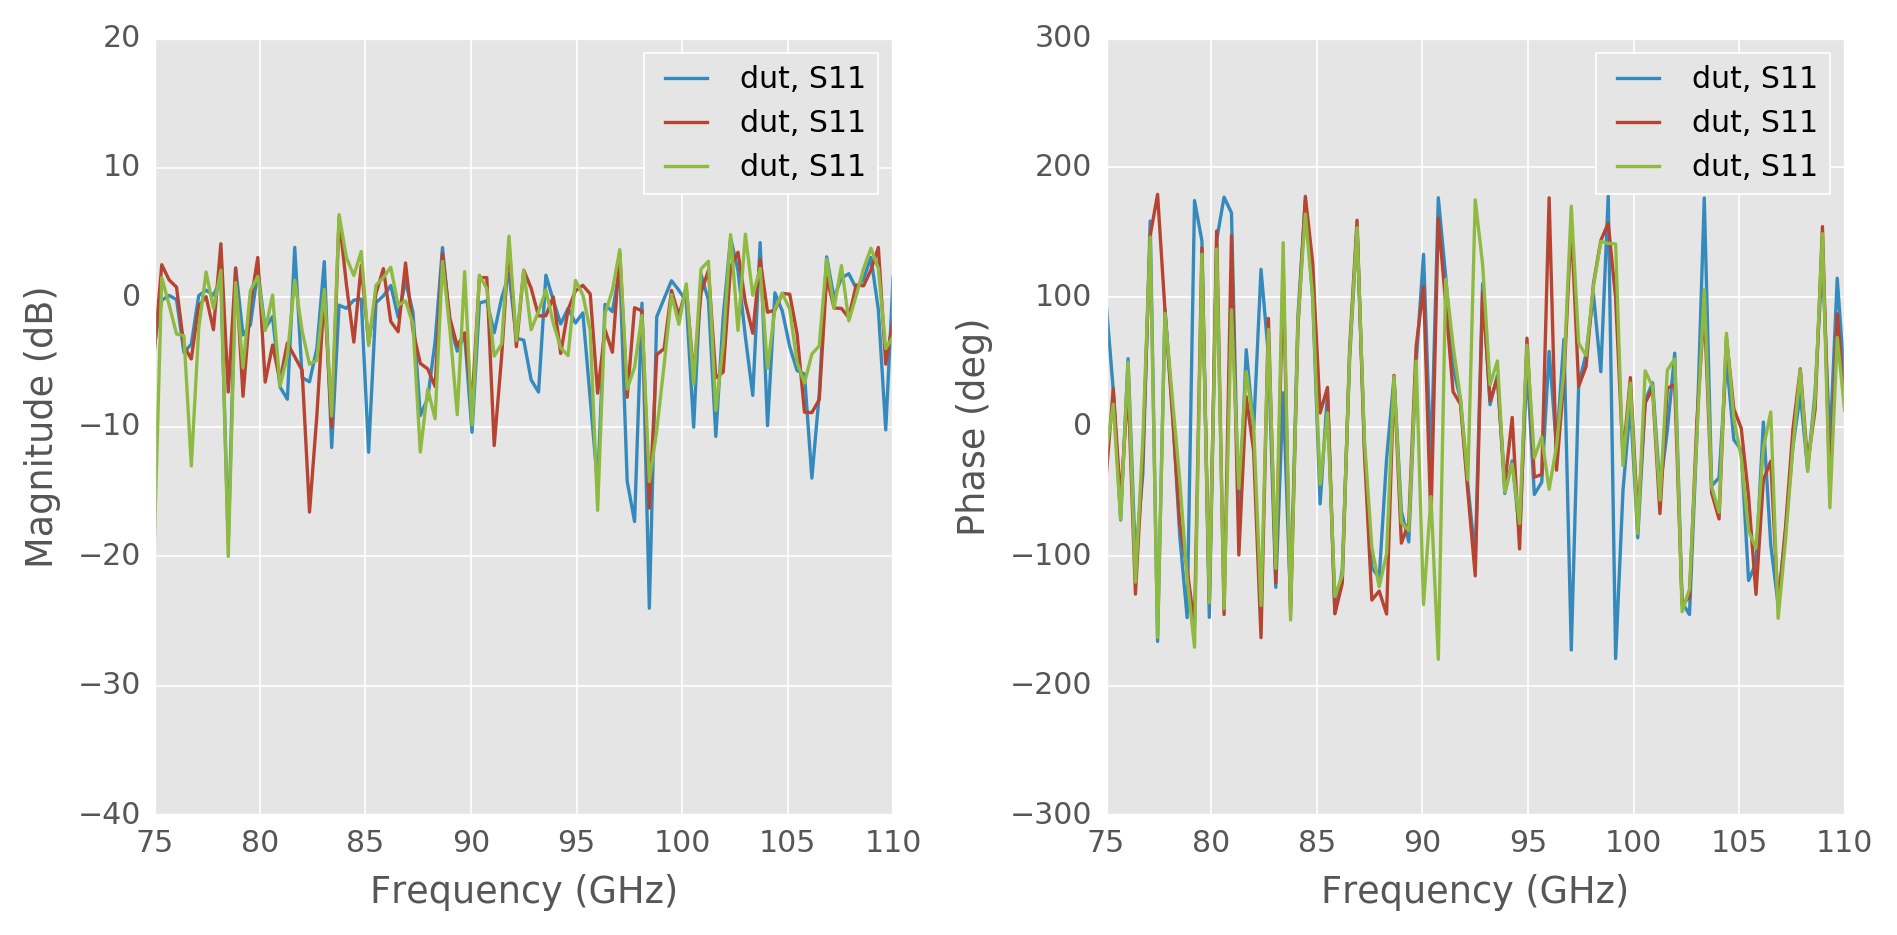

In [8]:
s11_set = rf.NS([measured[k] for k in measured if k[0]=='0'])

figure(figsize = (8,4))
subplot(121)
s11_set .plot_s_db(0,0)
subplot(122)
s11_set .plot_s_deg(0,0)
tight_layout()

However, the renormalized measurements agree perfectly. These plots answer to plots 6 and 8 of [1]

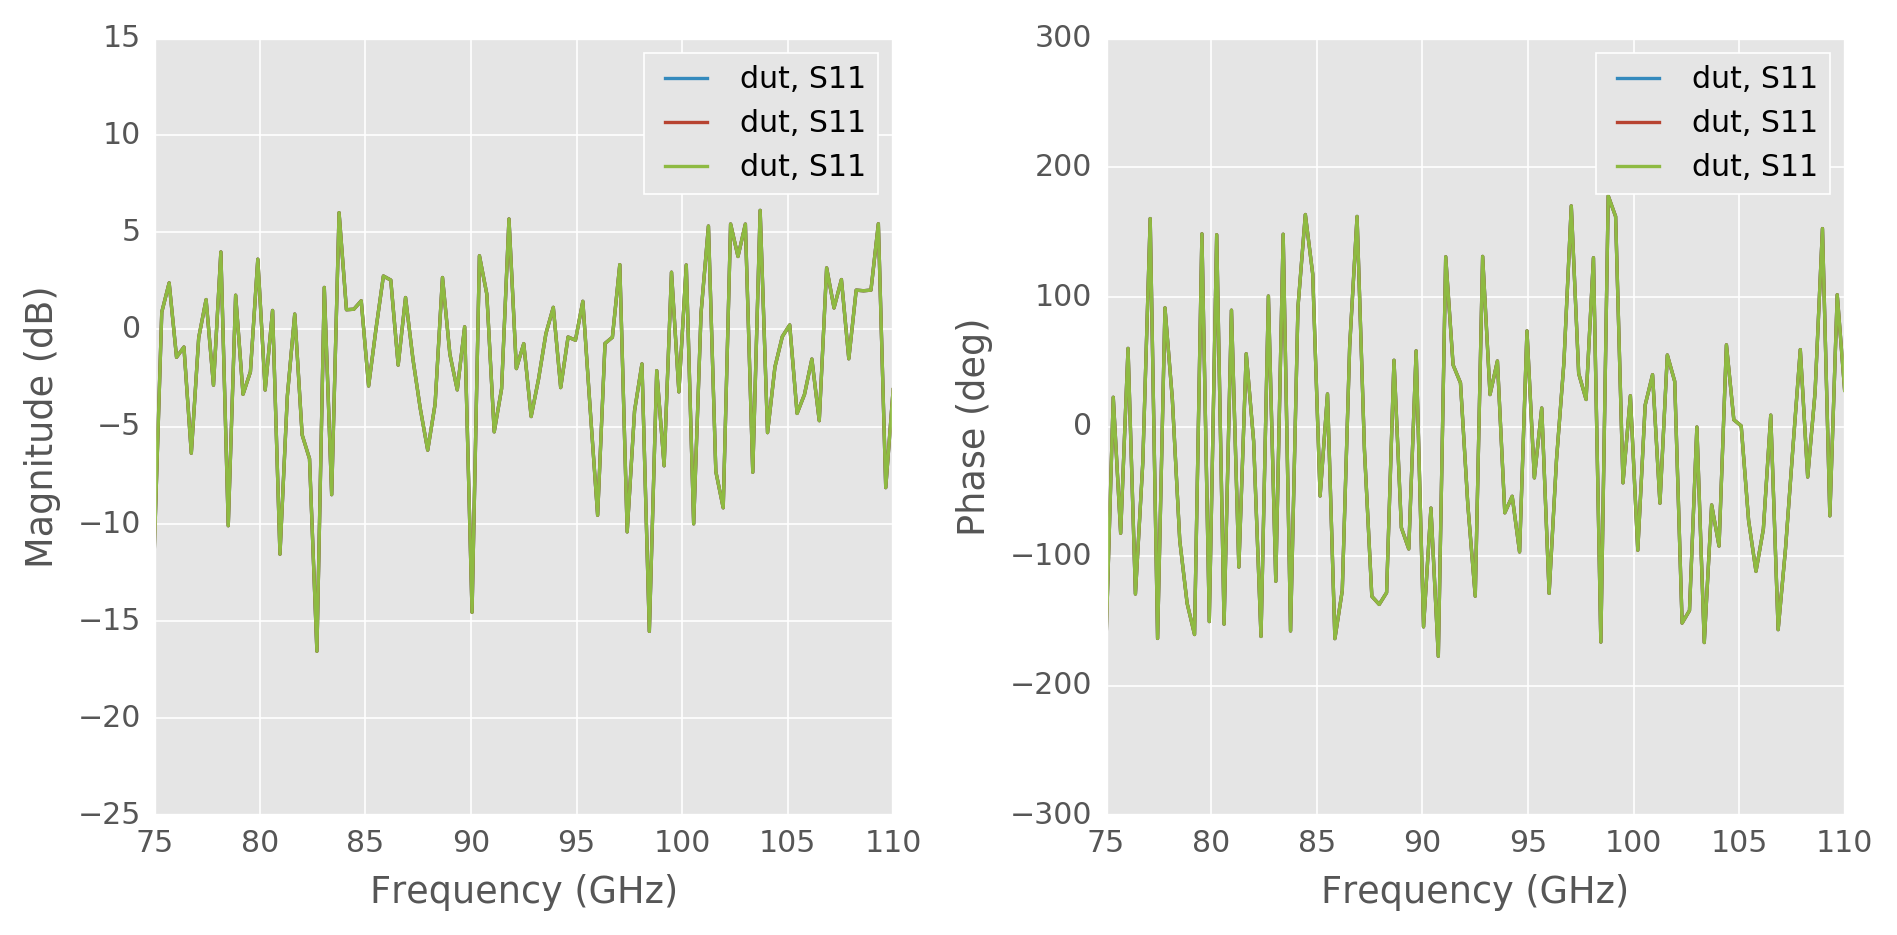

In [9]:
s11_set = rf.NS([measured_renorm[k] for k in measured_renorm if k[0]=='0'])

figure(figsize = (8,4))
subplot(121)
s11_set .plot_s_db(0,0)
subplot(122)
s11_set .plot_s_deg(0,0)
tight_layout()

### Test For Accuracy

Making sure our composite network is the same as our DUT

In [10]:
composite == dut

True

Nice!. How close ?

In [11]:
sum((composite - dut).s_mag)

1.082981252200624e-12

Dang!

## Practical Application

This could be used in many ways. In waveguide, one could just make a measurement of a radiating open after a standard two-port calibration (like TRL). Then using *Tippets technique*, you can  leave each port wide open while not being measured. This way you dont have to buy a bunch of loads. How sweet would that be?



## More Complex Simulations

In [12]:
def tippits(dut, gamma, noise=None):
    '''
    simulate tippits technique on a 4-port dut.
    '''
    ports = arange(dut.nports)
    port_combos = list(combinations(ports, 2))
    
    loads = [wg.load(gamma) for k in ports]
    
    # construct the impedance array, of shape FXN
    z_loads = array([k.z.flatten() for k in loads]).T
    composite = wg.match(nports = dut.nports)  # composite network, to be filled.
    #measured,measured_renorm = {},{}  # measured subnetworks and renormalized sub-networks


    # ports  `a` and `b` are the ports we will connect the VNA too
    for a,b in port_combos:
        # port `c` and `d` are the ports which we will connect the loads too
        c,d =ports[(ports!=a)& (ports!=b)] 

        # determine where `d` will be on four_port, after its reduced to a three_port
        e = where(ports[ports!=c]==d)[0][0]

        # connect loads
        three_port = rf.connect(dut,c, loads[c],0)
        two_port =  rf.connect(three_port,e, loads[d],0)
        
        if noise is not None:
            two_port.add_noise_polar(*noise)
        # save raw and renormalized 2-port subnetworks
        measured['%i%i'%(a,b)] = two_port.copy()
        two_port.renormalize(c_[z_loads[:,a],z_loads[:,b]])
        measured_renorm['%i%i'%(a,b)] = two_port.copy()

        # stuff this 2-port into the composite 4-port 
        for i,m in enumerate([a,b]):
            for j,n in enumerate([a,b]):
                composite.s[:,m,n] = two_port.s[:,i,j]

        # properly copy the port impedances
        composite.z0[:,a] = two_port.z0[:,0]
        composite.z0[:,b] = two_port.z0[:,1]


    # finally renormalize from 
    composite.renormalize(50)
    
    return composite


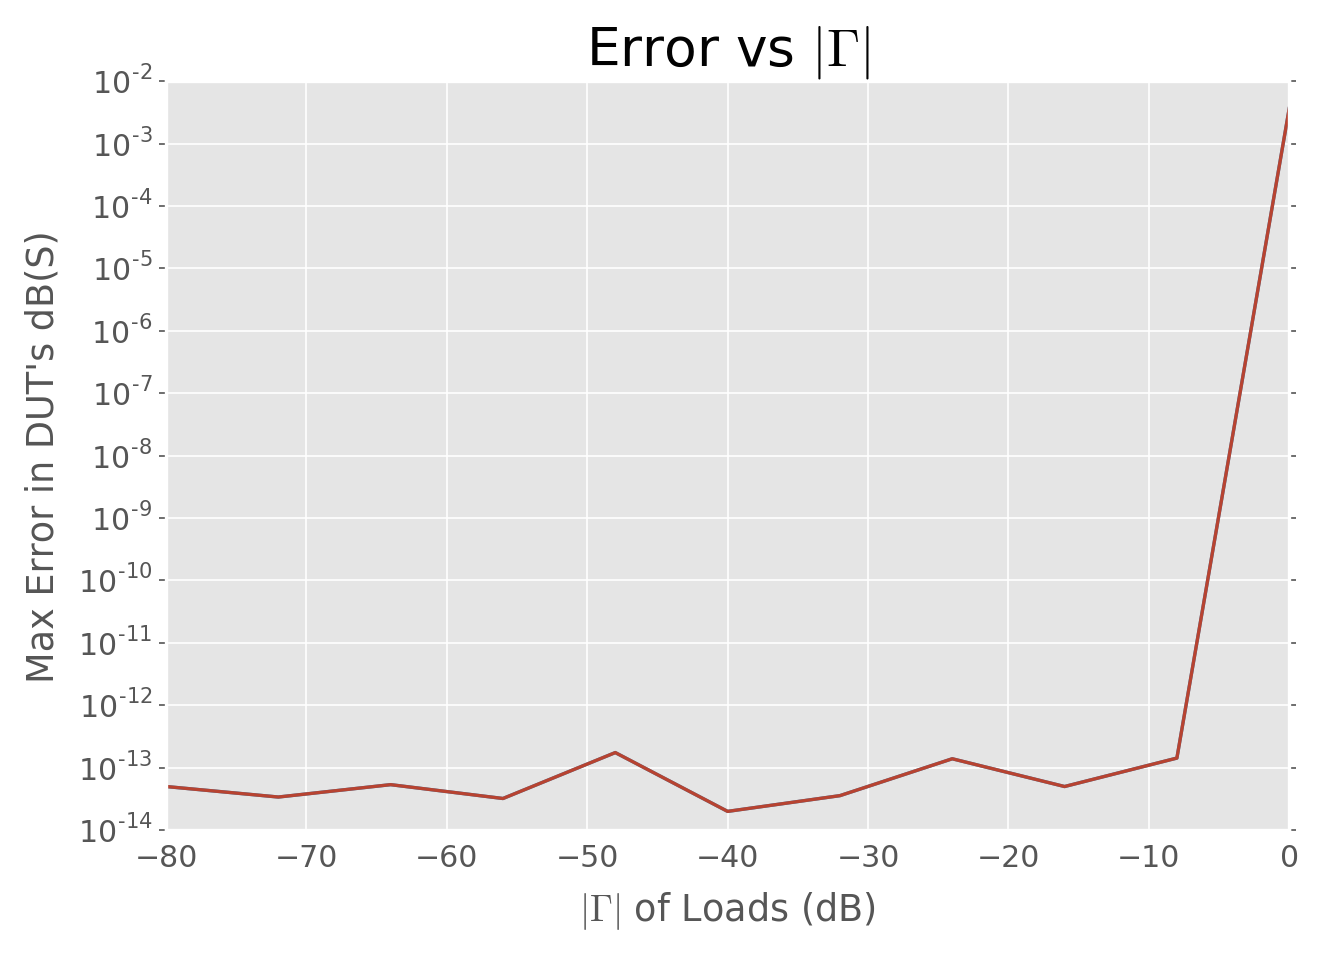

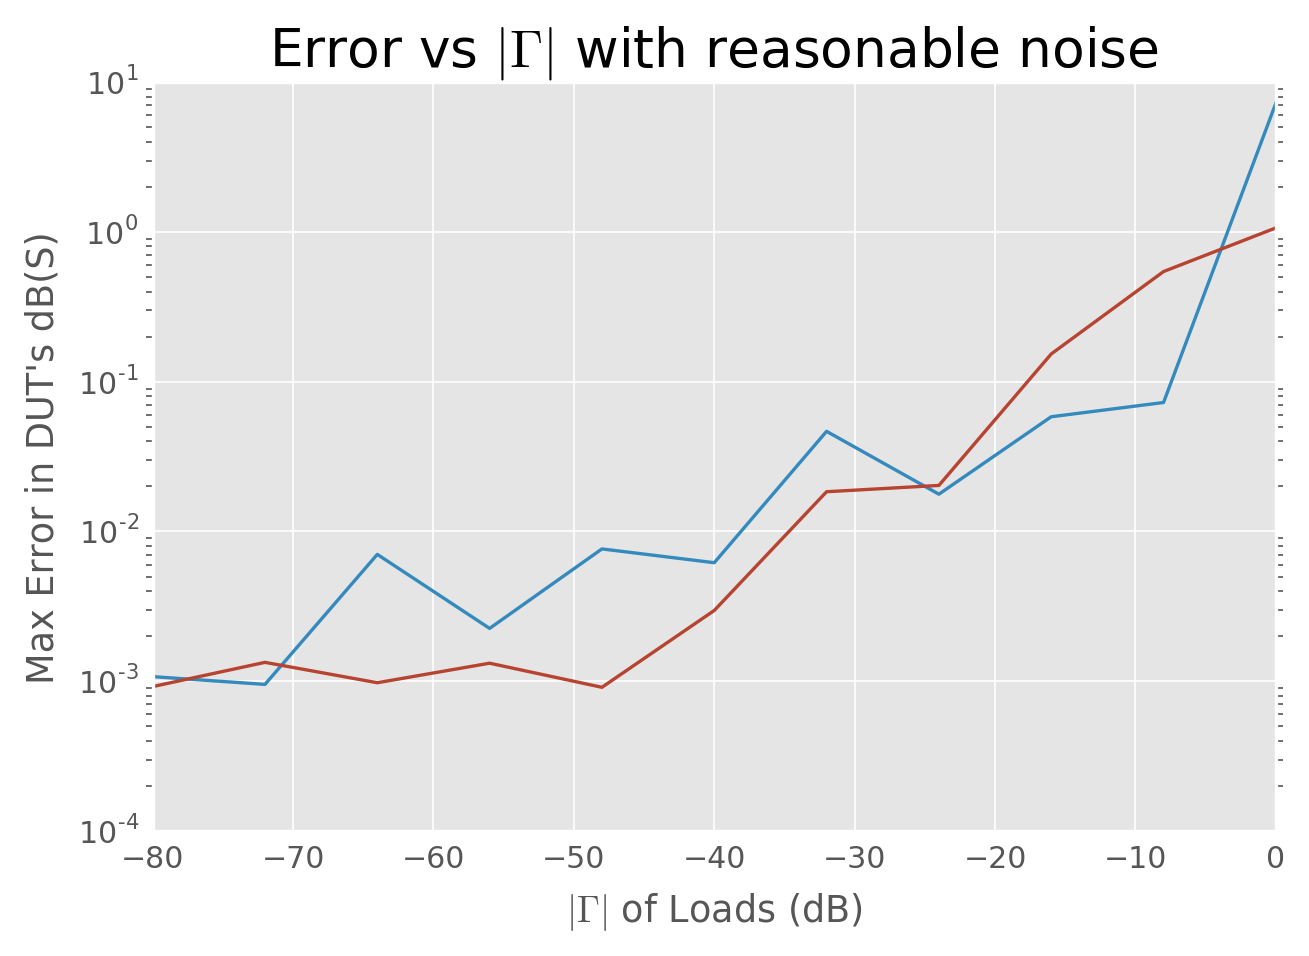

In [13]:
wg.frequency.npoints = 11
dut = wg.random(4)

#er = lambda gamma: mean((tippits(dut,gamma)-dut).s_mag)/mean(dut.s_mag)
def er(gamma, *args):
    return max(abs(tippits(dut, rf.db_2_mag(gamma),*args).s_db-dut.s_db).flatten())

gammas = linspace(-80,0,11)


title('Error vs $|\Gamma|$')
plot(gammas, [er(k) for k in gammas])
plot(gammas, [er(k) for k in gammas])
semilogy()
xlabel('$|\Gamma|$ of Loads (dB)')
ylabel('Max Error in DUT\'s dB(S)')



figure()

#er = lambda gamma: max(abs(tippits(dut,gamma,(1e-5,.1)).s_db-dut.s_db).flatten())
noise = (1e-5,.1)
title('Error vs $|\Gamma|$ with reasonable noise')
plot(gammas, [er(k, noise) for k in gammas])
plot(gammas, [er(k,noise) for k in gammas])
semilogy()
xlabel('$|\Gamma|$ of Loads (dB)')
ylabel('Max Error in DUT\'s dB(S)')